In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
import copy
import seaborn as sns

from utils import *
from lag_test_utils import *
from scipy.optimize import root_scalar

import matplotlib as mpl
import pandas as pd
import multiprocessing

# Set the default font and size
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

In [2]:
import pickle
n_rho=40

# head-to-head
pool_size=2
fracs = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in tqdm(rholist):
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    # all_ids = []
    # for i in data:
    #     all_ids.extend(i[0][1]["ids"])
    # fracs.append(len([i for i in all_ids if i<pool_size/2])/len(all_ids))
    fracs_phi = []
    for i in data:
        # get the fraction of biomass of the sequential species
        ids = i[0][1]["ids"]
        bs = i[0][1]["bs"][-1]
        fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
    fracs.append(np.mean(fracs_phi))
fracs_2 = fracs

# in community
pool_size = 100
fracs = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in tqdm(rholist):
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    # all_ids = []
    # for i in data:
    #     all_ids.extend(i[0][1]["ids"])
    # fracs.append(len([i for i in all_ids if i<pool_size/2])/len(all_ids))
    fracs_phi = []
    for i in data:
        # get the fraction of biomass of the sequential species
        ids = i[0][1]["ids"]
        bs = i[0][1]["bs"][-1]
        fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
    fracs.append(np.mean(fracs_phi))
fracs_100 = fracs

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:01<00:00, 37.38it/s]


14 14 14


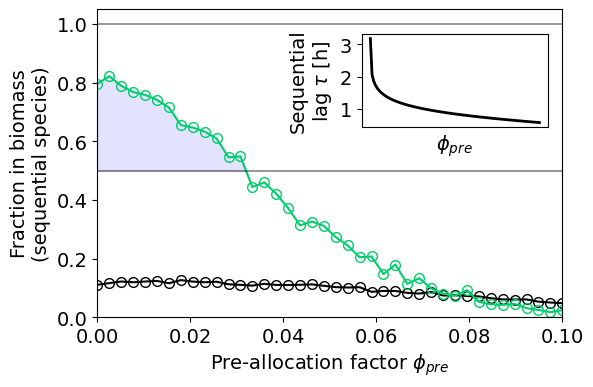

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create the main plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(rholist/4, fracs_2, markerfacecolor='none', color="k", marker='o', markersize=7, label="Head to head")
ax.plot(rholist/4, fracs_100, markerfacecolor='none', color="#00CD6C", marker='o', markersize=7, label="In community")
ax.set_xlabel("Pre-allocation factor $\\phi_{pre}$")
ax.set_ylabel("Fraction in biomass\n(sequential species)")
ax.axhline(1.0, color="k", alpha=0.4)
ax.axhline(0.5, color="k", alpha=0.4)
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 0.1)

x=list(rholist[:13]/4)+[0.032]
y1=fracs_100[:13]+[0.5]
y2=[0.5 for i in range(14)]
ax.fill_between(x, y1, y2, color="#7777ff", alpha=0.2)

def TaufSeq(Rs, rho, tau0):
    nr = len(Rs)
    return tau0*log((1-(nr-1)*rho/nr)/(rho/nr))
def TaufCout(Rs, rho, tau0):
    nr = len(Rs)
    nr_pres = np.sum(Rs>0)
    if(nr_pres==nr):
        # initial lag
        return tau0*log((1/nr)/(rho/nr))
    else:
        return tau0*log((1-(nr-nr_pres)*rho/nr)/(1-(nr-nr_pres-1)*rho/nr) * (nr_pres+1)/nr_pres)
rho_list = np.linspace(1e-4, 0.4, 100)
Rs = np.array([1, 1, 1, 0])
tau0 = 0.3
tau_list = [TaufSeq(Rs, rho, tau0) for rho in rho_list]

ax_inset = inset_axes(ax, width="40%", height="30%", loc='upper right', 
                     bbox_to_anchor=[-0.01, -0.05, 1, 1], bbox_transform=ax.transAxes)
ax_inset.plot(rho_list/4, tau_list, color="k", alpha=1, linewidth=2, label="Sequential utilizer")
# tau_list = [TaufCout(Rs, rho, tau0) for rho in rho_list]
# ax_inset.plot(rho_list/4, tau_list, color="r", alpha=0.4, linewidth=2, label="Coutilizer")
ax_inset.set_xlabel('$\\phi_{pre}$')
ax_inset.set_ylabel('Sequential\nlag $\\tau$ [h]')
ax_inset.set_xticks([], [])
# plt.savefig("fig2-1.pdf", bbox_inches="tight")
plt.show()

In [33]:
rholist[25]/4

0.06411153846153847

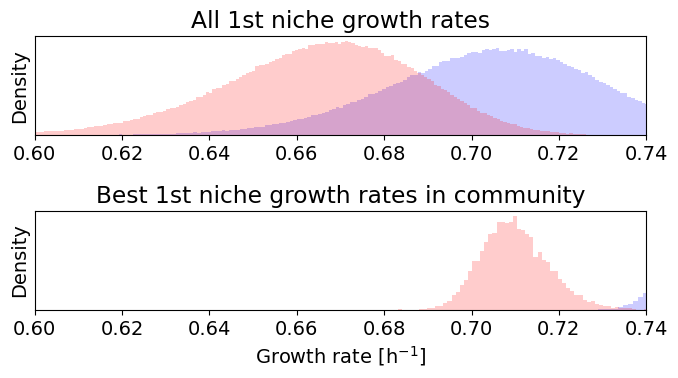

In [19]:
gC = 1
Nsamples = 10000
Npool = 50
R = 4

fig, axs = plt.subplots(2, 1, figsize=(7, 4))

g_diauxs_all = []
g_diauxs_max = []
g_couts_all = []
g_couts_max = []
rho = rholist[0]
for i in range(Nsamples):
    g1 = generate_g(Npool, R)
    g2 = generate_g(Npool, R)
    gt_1 = (rho+(1-rho)*R)*np.max(g1, axis=1)
    gt_2 = np.sum(g2, axis=1)+rho-rho
    g_diauxs_all.extend(list(1/(1/gt_1+1/gC)))
    g_couts_all.extend(list(1/(1/gt_2+1/gC)))
    g_diauxs_max.append(np.max(1/(1/gt_1+1/gC)))
    g_couts_max.append(np.max(1/(1/gt_2+1/gC)))
sns.histplot(g_diauxs_all, ax=axs[0], color="b", alpha = 0.2, stat="density", edgecolor="none", label="Sequential")
sns.histplot(g_couts_all, ax=axs[0], color="r", alpha = 0.2, stat="density", edgecolor="none", label="Coutilizing")
# axs[0].axvline(np.median(g_diauxs_all), color="b", alpha=0.35)
# axs[0].axvline(np.median(g_couts_all), color="r", alpha=0.35)
axs[0].set_xlim(0.60, 0.74)
axs[0].set_yticks([])
axs[0].set_yticklabels([])
# axs[0].set_xticks([0.6, 0.65, 0.7, 0.75])
axs[0].set_title("All 1st niche growth rates")
# axs[0].set_yscale("log")

# sns.histplot(g_diauxs_all, ax=axs[1], color="b", alpha = 0.2, stat="density", edgecolor="none", label="Sequential")
# sns.histplot(g_couts_all, ax=axs[1], color="r", alpha = 0.2, stat="density", edgecolor="none", label="Coutilizing")
# axs[1].set_xlim(0.7, 0.76)
# axs[1].set_yticks([])
# axs[1].set_yticklabels([])
# axs[1].set_yscale("log")

sns.histplot(g_diauxs_max, ax=axs[1], color="b", alpha = 0.2, stat="density", edgecolor="none", label="Sequential")
sns.histplot(g_couts_max, ax=axs[1], color="r", alpha = 0.2, stat="density", edgecolor="none", label="Coutilizing")
# axs[2].axvline(np.median(g_diauxs_max), color="b", alpha=0.35)
# axs[2].axvline(np.median(g_couts_max), color="r", alpha=0.35)
axs[1].set_xlim(0.60, 0.74)
axs[1].set_xlabel("Growth rate [h$^{-1}$]")
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_title("Best 1st niche growth rates in community")

fig.tight_layout()
plt.savefig("fig2-2.pdf", bbox_inches="tight")

In [24]:
rholist[25]/4

0.06411153846153847

In [1]:
import numpy as np
np.random.uniform(0, 0)

0.0

In [39]:
#colors = ['#6B4E71', '#B089A6', '#D6A7A1', '#E7CBA9']

In [20]:
n_rho = 40
D = 1000
rholist = np.linspace(1e-4, 0.4, n_rho)
Npairs = [(0, 1), (1, 0), (4, 0), (0, 4)]
all_t_deps = {Npair:[] for Npair in Npairs}
for Npair in Npairs:
    for rho in tqdm(rholist):
        all_t_deps[Npair].append([])
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/fitness_rho={rho}_Npair={Npair}.pkl", "rb"))
        all_t_deps[Npair][-1] = [log(D)/i["ts"][-2] for i in data]

100%|██████████| 40/40 [00:01<00:00, 38.73it/s]


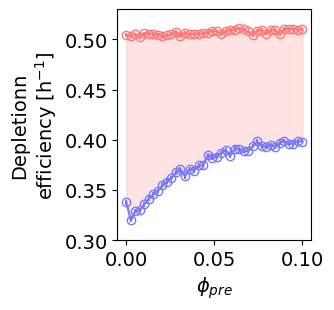

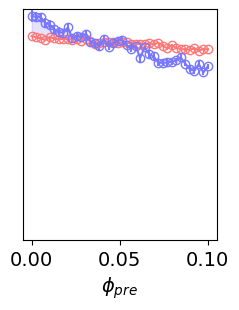

In [24]:
fig, ax = plt.subplots(figsize=(2.5, 3))
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(0, 1)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(0, 1)]], marker="o", 
             color="#ff7777", markerfacecolor='none', alpha=1, label="Coutilizing, single")
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(1, 0)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(1, 0)]], marker="o", 
             color="#7777ff", markerfacecolor='none', alpha=1, label="Sequential, single")
plt.xlabel("$\\phi_{pre}$")
plt.ylabel("Depletionn\nefficiency [h$^{-1}$]")
plt.ylim(0.3, 0.53)

x=list(rholist/4)
y1= [np.mean(i) for i in all_t_deps[(0, 1)]]
y2=[np.mean(i) for i in all_t_deps[(1, 0)]]
ax.fill_between(x, y1, y2, color="#ff7777", alpha=0.2)

plt.savefig("fig2-3-1.pdf", bbox_inches="tight")
plt.show()



fig, ax = plt.subplots(figsize=(2.5, 3))
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(0, 4)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(0, 4)]], marker="o", 
             color="#ff7777", markerfacecolor='none', alpha=1, label="Coutilizing, community")
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(4, 0)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(4, 0)]], marker="o", 
             color="#7777ff", markerfacecolor='none', alpha=1, label="Sequential, community")
plt.xlabel("$\\phi_{pre}$")
# plt.ylabel("Depletionn\nefficiency [h$^{-1}$]")
plt.yticks([], [])
plt.ylim(0.3, 0.53)

x=list(rholist/4)[:15]
y1= [np.mean(i) for i in all_t_deps[(0, 4)]][:15]
y2=[np.mean(i) for i in all_t_deps[(4, 0)]][:15]
ax.fill_between(x, y1, y2, color="#7777ff", alpha=0.2)

plt.savefig("fig2-3-2.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# # estimation from first niche growth rates
# gmean, gsigma, gC, R, D = 0.5, 0.1, 1.0, 4, 1000
# fracs = []
# n_communities = 200
# rholist = np.linspace(1e-4, 0.4, n_rho)
# for rho in tqdm(rholist):
#     # generate 200 communities with such rho
#     all_ids = []
#     for comm in range(n_communities):
#         Nseq, Ncout = int(pool_size/2), int(pool_size/2)
#         g_seq = generate_g(Nseq, R, gmean, gsigma)
#         permutations = list(itertools.permutations(list(range(1, R+1))))
#         pref_list = np.array(random.choices(permutations, k=Nseq))
#         col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
#         for row_i, row in enumerate(pref_list):
#             index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
#             row[0], row[index] = row[index], row[0]
#         g_cout = generate_g(Ncout, R, gmean, gsigma)
#         species_list = []
#         for i in range(Nseq):
#             species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=i))
#         for i in np.arange(Nseq, Nseq+Ncout):
#             species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=i))
#         for spc in species_list:
#             spc.GetEating(np.ones(4))
#         def get_top_n(lst, f, g, y, N=1):
#             # Filter the list by condition g(x) = y
#             filtered_lst = [x for x in lst if g(x) == y]
#             # Sort the filtered list by f(x) in descending order
#             sorted_lst = sorted(filtered_lst, key=f, reverse=True)
#             return sorted_lst[:N]
#         new_species_list = get_top_n(species_list, f=lambda x: x.GetGrowthRate(),
#                                             g = lambda x: 1, y=1, N=4)
#         all_ids.extend([spc.id for spc in new_species_list])
#     fracs.append(len([i for i in all_ids if i<pool_size/2])/len(all_ids))
# fracs_100_null = fracs